# NFL Big Data Bowl 2024


## Attempting to predict direction and pass/run of the play based on pre-snap information.


## Importing dataview libraries


In [1]:
import re

import pandas as pd
import numpy as np

from xgboost import XGBClassifier

import nfl_data_py as nfl


In [2]:
DATA_ROOT = '../data/'

In [3]:
raw = nfl.import_pbp_data(range(2022, 2024))
all_cols = nfl.see_pbp_cols()

2022 done.
2023 done.
Downcasting floats.


In [4]:
for col in all_cols:
    print(col)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [5]:
raw.posteam.value_counts()

posteam
PHI    2562
DAL    2517
WAS    2511
NYG    2494
KC     2476
MIN    2469
SF     2455
CIN    2417
TB     2409
LAC    2406
JAX    2397
BUF    2375
ARI    2368
DET    2363
CLE    2354
SEA    2347
BAL    2344
MIA    2313
IND    2284
NYJ    2266
GB     2231
LV     2219
DEN    2217
CHI    2213
PIT    2212
NO     2208
ATL    2178
HOU    2177
CAR    2164
NE     2127
LA     2125
TEN    2090
Name: count, dtype: int64

In [6]:
df = raw.copy()

In [7]:
cols = ['yardline_100', 'down', 'ydstogo', 'goal_to_go', 'play_type', 'score_differential', 'defenders_in_box', 'posteam', 'defteam', 'offense_formation', 'defense_personnel', 'run_location', 'run_gap', 'pass_length', 'pass_location']
df = df[cols]
play_type_mask = df['play_type'].isin(['kickoff', 'no_play', 'punt', 'field_goal', 'extra_point', 'qb_kneel', 'qb_spike', None])
df = df[~play_type_mask]
df = df[df['defense_personnel'].notnull()]
df = df[df.down != 4]
# df = df[df.down != 1]

In [8]:
def make_play_string(row):
    ret_str = ''
    if row['play_type'] == 'pass':
        ret_str += 'pass-'
        if row['pass_length'] == 'short':
            ret_str += 'short-'
        elif row['pass_length'] == 'deep':
            ret_str += 'deep-'
        if row['pass_location'] == 'left':
            ret_str += 'left'
        elif row['pass_location'] == 'middle':
            ret_str += 'middle'
        elif row['pass_location'] == 'right':
            ret_str += 'right'
        if ret_str == 'pass-':
            ret_str += 'other'
    elif row['play_type'] == 'run':
        ret_str += 'run-'
        if row['run_location'] == 'left':
            ret_str += 'left-'
        elif row['run_location'] == 'middle':
            ret_str += 'middle'
            return ret_str # Short circuit for now
        elif row['run_location'] == 'right':
            ret_str += 'right-'
        else:
            return 'ERROR'
        if row['run_gap'] == 'end':
            ret_str += 'end'
        elif row['run_gap'] == 'guard':
            ret_str += 'guard'
        elif row['run_gap'] == 'tackle':
            ret_str += 'tackle'
        else:
            return 'ERROR'
    else:
        return 'ERROR'
    return ret_str

def clean_personnel_string(row):
    input_str = row['defense_personnel']
    input_str = input_str.replace(' ', '')
    input_str = input_str.replace(',', '-')
    return input_str

In [9]:
df['play_string'] = df.apply(make_play_string, axis=1)
df = df[df.play_string != 'ERROR']
df['play_string'].value_counts()

play_string
pass-short-right     10106
pass-short-left       9128
run-middle            5834
pass-short-middle     5187
run-left-end          3204
run-right-end         2940
run-right-guard       2861
run-left-guard        2822
run-left-tackle       2814
run-right-tackle      2559
pass-other            2330
pass-deep-right       2116
pass-deep-left        2065
pass-deep-middle      1003
Name: count, dtype: int64

In [10]:
df['defense_personnel'] = df.apply(clean_personnel_string, axis=1)
df['defense_personnel'].value_counts()

defense_personnel
4DL-2LB-5DB        14819
2DL-4LB-5DB         9903
3DL-3LB-5DB         9604
3DL-4LB-4DB         6500
4DL-3LB-4DB         5089
                   ...  
6DL-3LB-3DB            1
1DL-2LB-7DB-1WR        1
3DL-6LB-2DB            1
2DL-1LB-7DB            1
7DL-2LB-2DB            1
Name: count, Length: 65, dtype: int64

In [11]:
numerical_cols = ['yardline_100', 'ydstogo', 'score_differential', 'defenders_in_box']
categorical_cols = ['down', 'offense_formation', 'defense_personnel', 'goal_to_go', 'posteam', 'defteam']
target_col = 'play_string'
target_raw = df[target_col].copy()

In [12]:
from sklearn.preprocessing import LabelEncoder

df = df[numerical_cols + categorical_cols + [target_col]]
les = {}
for col in categorical_cols+[target_col]:
    les[col] = LabelEncoder()
    df[col] = les[col].fit_transform(df[col])
df = df.dropna()

array([[<Axes: title={'center': 'yardline_100'}>,
        <Axes: title={'center': 'ydstogo'}>,
        <Axes: title={'center': 'score_differential'}>],
       [<Axes: title={'center': 'defenders_in_box'}>,
        <Axes: title={'center': 'down'}>,
        <Axes: title={'center': 'offense_formation'}>],
       [<Axes: title={'center': 'defense_personnel'}>,
        <Axes: title={'center': 'goal_to_go'}>,
        <Axes: title={'center': 'posteam'}>],
       [<Axes: title={'center': 'defteam'}>, <Axes: >, <Axes: >]],
      dtype=object)

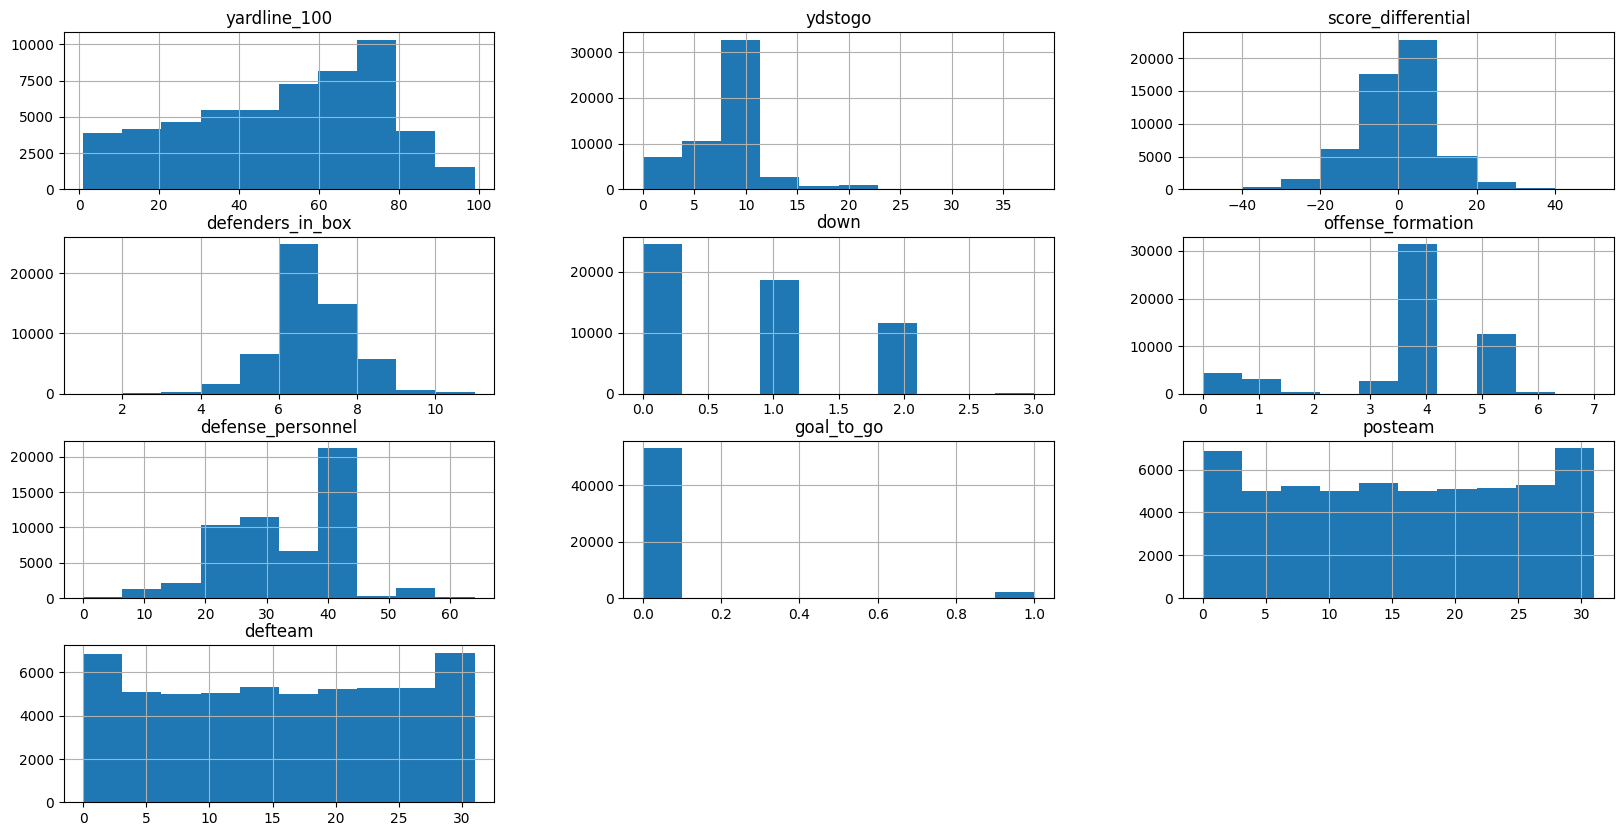

In [13]:
df.hist(column=numerical_cols+categorical_cols, figsize=(20, 10))

In [14]:
target = df.pop(target_col)

In [15]:
from sklearn.model_selection import train_test_split

X_big, X_test, y_big, y_test = train_test_split(df, target, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_big, y_big, test_size=0.2)

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

LR = 0.2

def get_class_score(n_estimators, max_depth, max_leaves, learning_rate):
    clf = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        max_leaves=max_leaves,
                        learning_rate=learning_rate,
                        n_jobs=12,
                        early_stopping_rounds=10,
                        random_state=0)
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print (f'Estimators: {n_estimators}, Depth: {max_depth}, Leaf: {max_leaves}, LR: {learning_rate}, Accuracy: {acc}')
    return acc, classification_report(y_val, preds, target_names=les[target_col].classes_, zero_division=0)

Estimators: 200, Depth: 1, Leaf: 0, LR: 0.2, Accuracy: 0.20477544059124503
Estimators: 200, Depth: 2, Leaf: 0, LR: 0.2, Accuracy: 0.20932347924957362
Estimators: 200, Depth: 3, Leaf: 0, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 4, Leaf: 0, LR: 0.2, Accuracy: 0.20477544059124503
Best depth: 3


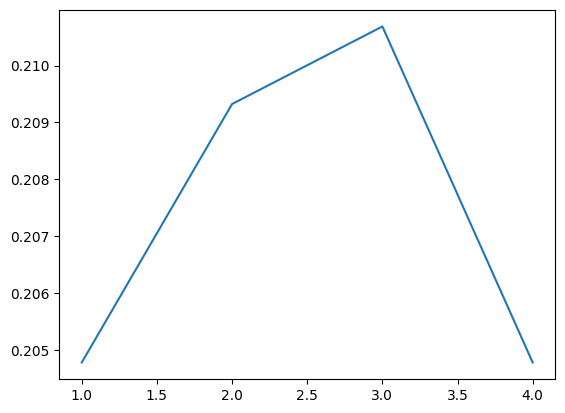

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

depth_scores = dict([(d, get_class_score(200, d, 0, LR)) for d in range(1, 5)])
plt.plot(list(depth_scores.keys()), [x[0] for x in depth_scores.values()])
temp_best_depth = max(depth_scores, key=depth_scores.get)
best_depth = temp_best_depth
print(f'Best depth: {best_depth}')


Estimators: 200, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 9, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 10, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 11, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 12, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 13, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 14, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 15, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 16, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 17, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 18, LR: 0.2, Accuracy: 0.2106878908470722
Estimators: 200, Depth: 3, Leaf: 19, LR: 0.2, Accuracy: 0.2106878908470722
Best leaf: 8


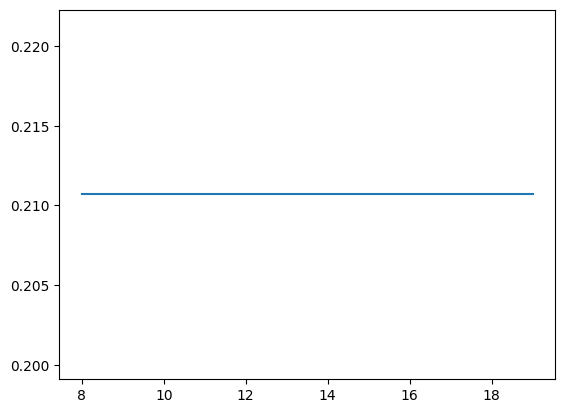

In [18]:
leaf_scores = dict([(l, get_class_score(200, best_depth, l, LR)) for l in range(8, 20)])
plt.plot(list(leaf_scores.keys()), [x[0] for x in leaf_scores.values()])
temp_best_leaf = max(leaf_scores, key=leaf_scores.get)
best_leaf = temp_best_leaf
print(f'Best leaf: {best_leaf}')

Estimators: 400, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20477544059124503
Estimators: 420, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.2044343376918704
Estimators: 440, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20511654349061967
Estimators: 460, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.2038658328595793
Estimators: 480, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20466173962478681
Estimators: 500, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20568504832291074
Estimators: 520, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20375213189312108
Estimators: 540, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.2044343376918704
Estimators: 560, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20488914155770324
Estimators: 580, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.2054576463899943
Estimators: 600, Depth: 3, Leaf: 8, LR: 0.2, Accuracy: 0.20557134735645252
Best est: 500


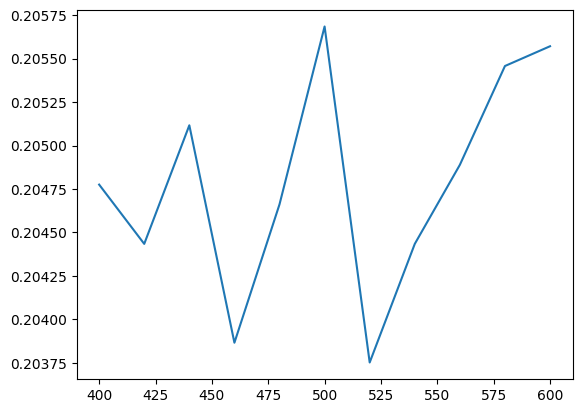

In [19]:
est_scores = dict([(est, get_class_score(est, best_depth, best_leaf, LR)) for est in range(400, 601, 20)])
plt.plot(list(est_scores.keys()), [x[0] for x in est_scores.values()])
temp_best_est = max(est_scores, key=est_scores.get)
best_est = temp_best_est
print(f'Best est: {best_est}')

In [20]:
final_clf = XGBClassifier(n_estimators=best_est, max_depth=best_depth, max_leaves=best_leaf, learning_rate=LR, n_jobs=12)
final_clf.fit(X_big, y_big)
preds = final_clf.predict(X_test)
print(classification_report(y_test, preds, target_names=les[target_col].classes_, zero_division=0))

                   precision    recall  f1-score   support

   pass-deep-left       0.00      0.00      0.00       420
 pass-deep-middle       0.00      0.00      0.00       186
  pass-deep-right       0.08      0.00      0.00       425
       pass-other       0.57      0.07      0.13       462
  pass-short-left       0.21      0.31      0.25      1781
pass-short-middle       0.22      0.06      0.09      1078
 pass-short-right       0.22      0.49      0.31      2012
     run-left-end       0.17      0.09      0.12       658
   run-left-guard       0.13      0.03      0.05       588
  run-left-tackle       0.13      0.09      0.11       562
       run-middle       0.22      0.35      0.27      1169
    run-right-end       0.13      0.06      0.08       550
  run-right-guard       0.17      0.07      0.10       586
 run-right-tackle       0.11      0.05      0.06       517

         accuracy                           0.21     10994
        macro avg       0.17      0.12      0.11     1

In [21]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(df.columns),)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(les[target_col].classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

2023-11-26 11:39:49.819909: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2023-11-26 11:39:49.819937: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2023-11-26 11:39:49.819943: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2023-11-26 11:39:49.820309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-26 11:39:49.820338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-11-26 11:39:50.331225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1100/1100 [==============================] - 10s 8ms/step - loss: 3.2574 - accuracy: 0.1501 - val_loss: 2.6124 - val_accuracy: 0.1874
Epoch 2/100
1100/1100 [==============================] - 8s 7ms/step - loss: 2.6854 - accuracy: 0.1569 - val_loss: 2.8678 - val_accuracy: 0.1371
Epoch 3/100
1100/1100 [==============================] - 8s 7ms/step - loss: 3.5251 - accuracy: 0.1364 - val_loss: 6.2892 - val_accuracy: 0.1088
Epoch 4/100
1100/1100 [==============================] - 8s 7ms/step - loss: 11.3773 - accuracy: 0.1120 - val_loss: 20.5862 - val_accuracy: 0.1115
Epoch 5/100
1100/1100 [==============================] - 8s 7ms/step - loss: 27.0388 - accuracy: 0.1059 - val_loss: 43.4843 - val_accuracy: 0.0956
Epoch 6/100
1100/1100 [==============================] - 8s 8ms/step - loss: 44.3061 - accuracy: 0.1019 - val_loss: 71.7422 - val_accuracy: 0.0617
Epoch 7/100
1100/1100 [==============================] - 8s 7ms/step - loss: 64.9486 - accuracy: 0.1030 - val_loss: 110.6995 - val_accu